# Implementing a Transformer from Scratch



In this exercise, you will implement key components of the Transformer architecture, a cornerstone in modern natural language processing technology, introduced by the ["Attention is All You Need" paper](https://arxiv.org/abs/1706.03762).

Your task involves coding missing parts within this notebook, which sketches out the structure of a Transformer block. This will include layer normalization, MLP, and attention mechanism. All the pieces you implement will be then put toghether to define an actual Tranformer-based model. Finally, you will load the pre-trained GPT-2 weights into your model and implement a simple decoding function to generate text from it.

## Overview of the Transformer Architecture

In a Tranformer-based model, the input is initially converted into token embeddings. Then it progresses through a set of Transformer blocks consisting of the attention mechanism and feed-forward MLP layer. At each stage, the information is combined with a residual connection, ensuring the flow of both original and processed data throughout the model. Finally, the residual stream is projected back onto the vocabulary space via the unembedding procedure.


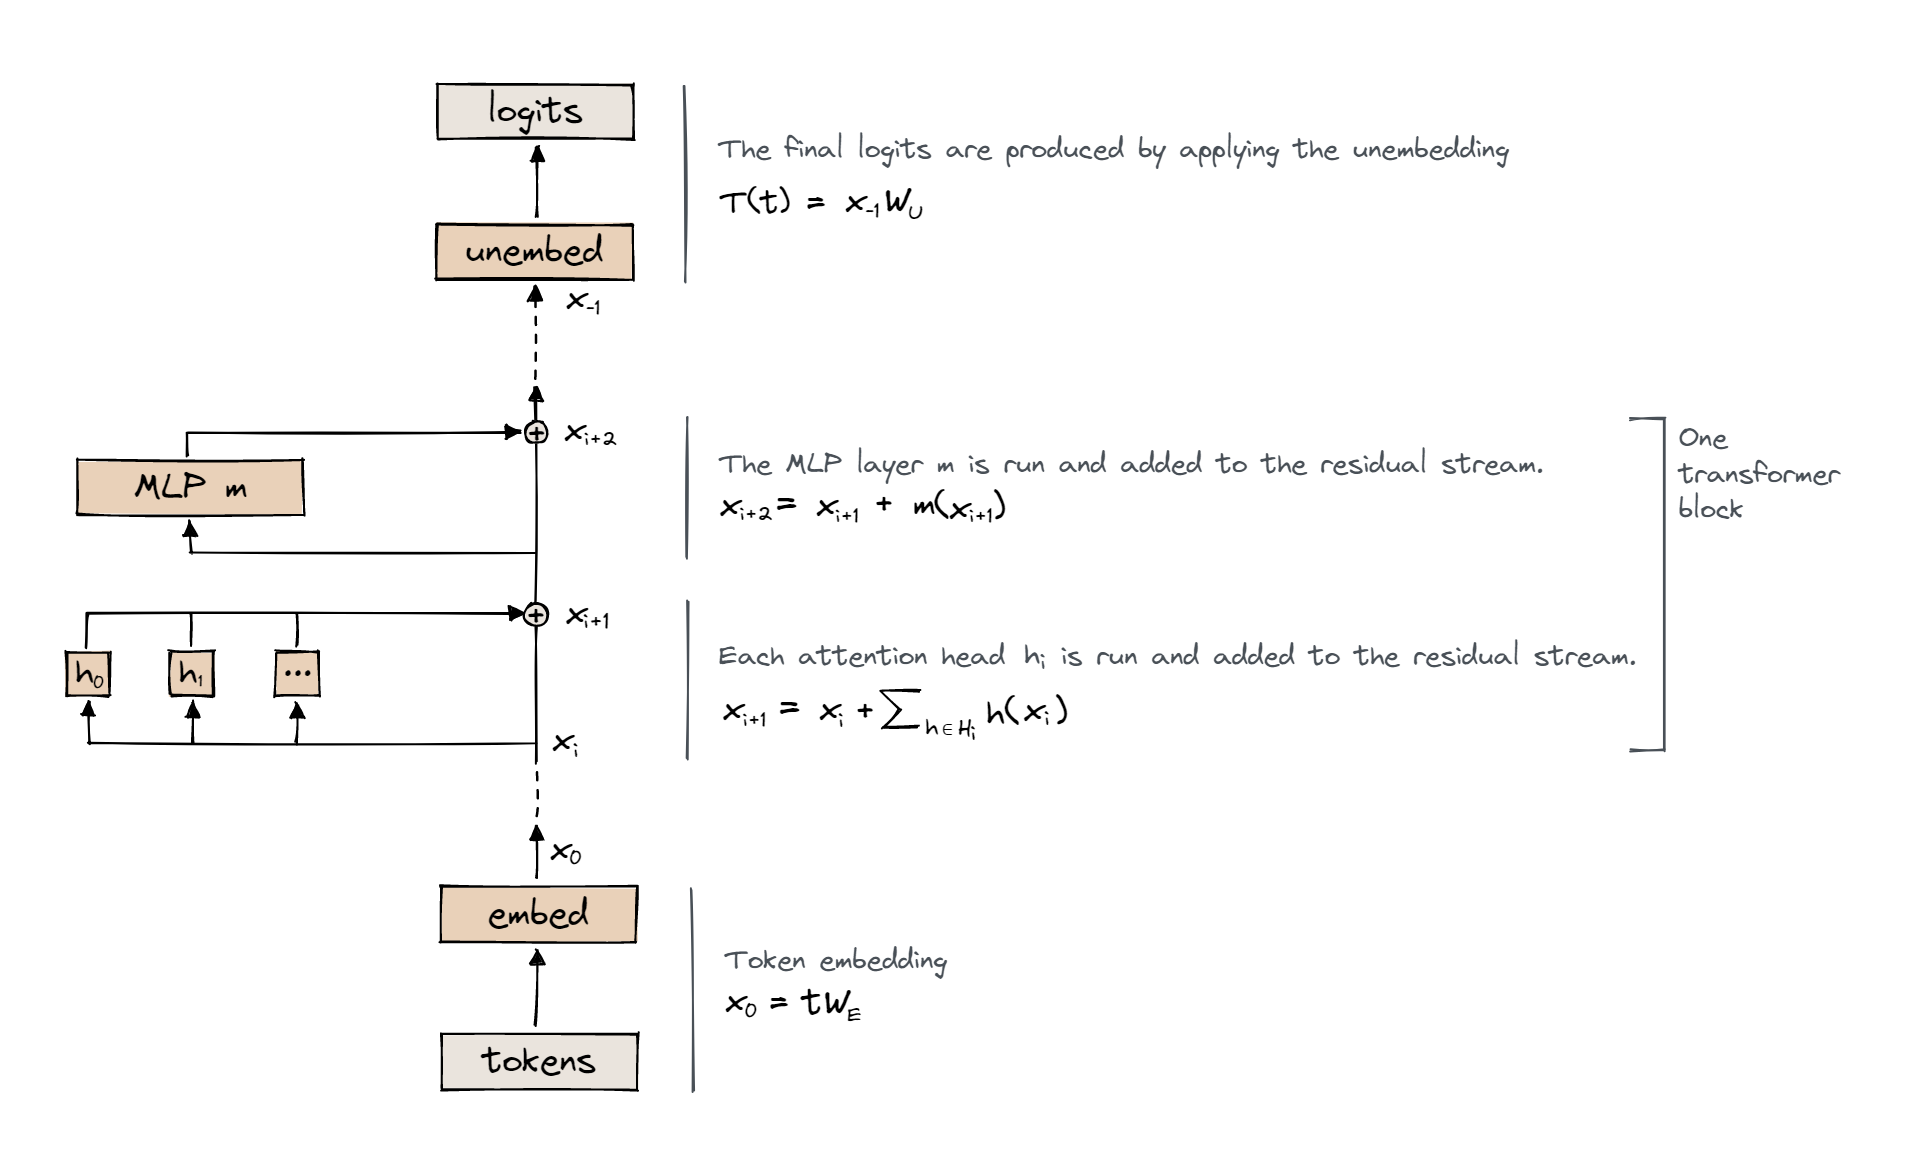

The streamlined visualization above omits two important components: layer normalization and positional embeddings.



**Layer Normalization**: Although not depicted, Layer Normalization is a standard procedure applied before each sub-component (MLP, attention layer) and prior to the final logits computation. It normalizes each vector within the batch and position to a mean of zero and variance of one, followed by an element-wise scale and translation.

**Positional Embeddings**: The diagram also excludes the representation of Positional Embeddings. In the absence of such embeddings, attention mechanisms would treat the input as positionally symmetric, neglecting the locality inherent in language where neighboring tokens are often more relevant. To address this, learned, absolute positional embeddings are used, where each token position is mapped to a unique vector and added to the token embeddings, reinforcing the model's awareness of token order. Addition rather than concatenation is the norm within Transformer architectures, conserving dimensionality and accommodating feature superposition within the shared residual stream.

## Setup (no need to read, just run!)

The following two cells install, import, and define some modules, functions, and variables that we will need throughout the exercise. No implementation from your side is required. You can just run them and head to the next section.

In [1]:
%pip install -q transformer_lens einops jaxtyping

Note: you may need to restart the kernel to use updated packages.


The pip command above might throw "ERROR: pip's dependency resolver does not  currently take into account [...]". This should not be a problem and you should be able to execture the next cell without errors.

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
from dataclasses import dataclass
from transformer_lens import HookedTransformer
from jaxtyping import Float, Int
from transformer_lens.utils import gelu_new
import einops

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

reference_gpt2 = HookedTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)

reference_text = "Today we are going to implement a Transformer from scratch!"
tokens = reference_gpt2.to_tokens(reference_text).to(device)
logits, cache = reference_gpt2.run_with_cache(tokens)

@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12

cfg = Config()


# define tests
def rand_float_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    random_input = torch.randn(shape).to(device)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    if isinstance(output, tuple): output = output[0]
    print("Output shape:", output.shape, "\n")

def rand_int_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    random_input = torch.randint(100, 1000, shape).to(device)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    if isinstance(output, tuple): output = output[0]
    print("Output shape:", output.shape, "\n")

def load_gpt2_test(cls, gpt2_layer, input):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    print("Input shape:", input.shape)
    output = layer(input)
    if isinstance(output, tuple): output = output[0]
    print("Output shape:", output.shape)
    try: reference_output = gpt2_layer(input)
    except: reference_output = gpt2_layer(input, input, input)
    print("Reference output shape:", reference_output.shape, "\n")
    comparison = torch.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")

Loaded pretrained model gpt2-small into HookedTransformer


## Preliminaries

For each component of the Transformer architecture covered in this exercise, we provide you with a code skeleton that outlines the structure of the component and defines its parameters. Your task is to implement the forward pass of each component. This means you need to define how the parameters are used and combined with the input tensor to produce the output of the component.

### Typing
In the provided code skeleton for the Transformer components, you will notice an explicit typing notation used in the signature of the forward method. This notation serves a dual purpose: it enhances code readability and provides clear expectations for the input and output tensor dimensions. Here's a brief example of this typing:

`Float[Tensor, "batch posn d_model"]`: This notation specifies that the function expects a floating-point tensor with three dimensions. The dimensions are labeled for clarity:
- `batch` represents the size of the batch, or the number of sequences in each input batch.
- `posn` (position) indicates the length of each sequence in the batch.
- `d_model` is the dimensionality of each vector in the sequence, a key parameter in Transformer models representing the size of the embeddings and residual stream.

This explicit typing convention is a guide to help you correctly manipulate tensors, ensuring that your implementation aligns with the expected input and output dimensions.

### Tests

Throughout the exercise, we employ a series of tests to validate the correctness of your implementation of Transformer components.

After you write your code, two tests will verify your solution:
- `rand_float_test`/`rand_float_test` will check the correctness of the output dimensionality of your function.
- `load_gpt2_test` compares the output of your implementation with that of a corresponding component from a pre-trained GPT-2 model to ensure correctness.

## Q1: LayerNorm (3 pts)

This part of the exercise involves implementing Layer Normalization (LayerNorm) within the Transformer architecture. LayerNorm is a technique in deep learning that stabilizes the distribution of the inputs to a layer. It is especially important in Transformers to help control the scale of the outputs across different layers, which in turn aids in faster convergence and improved overall model performance.

In particular, your implementation of LayerNorm should do the following:
- center the residual stream (such that it has mean 0)
- normalize it to have variance 1
- re-scale it according to the learned weights
- add the learned bias

You can refer to the [PyTorch LayerNorm documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

Replace the `pass` instruction below with your solution.

**Warning:** refrain from using in-place operations (e.g., `x += y`) as they might lead to random test failuers due to small numerical differences.

**Hint:** compute the variance of the residual stream values using `residual.var(..., unbiased=False)`.

**Hint:** the value of $\epsilon$ is `self.cfg.layer_norm_eps`.

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.d_model))
        self.b = nn.Parameter(torch.zeros(cfg.d_model))

    def forward(self, residual: Float[Tensor, "batch posn d_model"]) -> Float[Tensor, "batch posn d_model"]:
        # implement your solution here
        # Calculate the mean and variance of the residual tensor along the last dimension
        mean = residual.mean(dim=-1, keepdim=True)
        var = residual.var(dim=-1, keepdim=True, unbiased=False)
        # Normalize the residual tensor using the mean and variance
        std = torch.sqrt(var + self.cfg.layer_norm_eps)
        normalized_residual = (residual - mean) / std
        # Apply the learned scale and bias parameters
        output = self.w * normalized_residual + self.b
        return output

rand_float_test(LayerNorm, [2, 4, 768])
load_gpt2_test(LayerNorm, reference_gpt2.ln_final, cache["resid_post", 11])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 13, 768])
Output shape: torch.Size([1, 13, 768])
Reference output shape: torch.Size([1, 13, 768]) 

100.00% of the values are correct



## Q2: Embedding (2 pts)

The embedding layer is the entry point of textual data into the Transformer model, where tokens are transformed into dense vectors. This transformation is crucial as it allows the model to work with  continuous representations of words or subwords, setting the stage for subsequent processing by the model's layers.

Your task is to complete the `forward` method of the `Embed` class. This method should map each token in the input sequence to a high-dimensional vector using an embedding matrix.

- **Embedding Matrix**: The class is initialized with an embedding matrix `W_E` of shape `[cfg.d_vocab, cfg.d_model]`, where `cfg.d_vocab` is the size of the vocabulary, and `cfg.d_model` is the dimensionality of the embeddings. This matrix is a learnable parameter of the model.
- **Token to Vector Transformation**: In the `forward` method, your goal is to transform the input tokens into their corresponding vectors based on the embedding matrix. The input tensor `tokens` has a shape of `[batch, position]`, indicating a batch of token sequences.
- **Output**: The output of the `forward` method should be a tensor of shape `[batch, position, d_model]`, where each token has been replaced by its corresponding vector from the embedding matrix. This tensor represents the embedded input sequences and serves as the input to subsequent layers of the Transformer model.

In simple words, what you need to implement is a lookup table from tokens to residual stream vectors.

**Hint:** you can implement this in just one line, without any complicated functions.

In [4]:
class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(torch.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_model"]:
        #implement your solution here
        return self.W_E[tokens]
    
rand_int_test(Embed, [2, 4])
load_gpt2_test(Embed, reference_gpt2.embed, tokens)

Input shape: torch.Size([2, 4])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 13])
Output shape: torch.Size([1, 13, 768])
Reference output shape: torch.Size([1, 13, 768]) 

100.00% of the values are correct



## Q3: Positional Embeddings (2 pts)

Unlike traditional sequence models that inherently process sequences in a certain order (e.g., RNNs), Transformers treat input sequences as sets of tokens, requiring an explicit mechanism to incorporate positional information. Positional embeddings serve this function.

Positional embedding functions similarly to a lookup table, with the crucial difference that the lookup indices correspond to `0`, `1`, `2`, ..., `seq_len-1`, representing the positional indices of tokens within a sequence, instead of token IDs. This approach encodes the position of each token in the sequence, distinguishing their order.

- **Positional Embedding Matrix**: Upon initialization, `PosEmbed` creates a positional embedding matrix `W_pos` of shape `[cfg.n_ctx, cfg.d_model]`, where `cfg.n_ctx` is the maximum sequence length the model can handle, and `cfg.d_model` is the dimensionality of the embeddings. This matrix is a learnable parameter and contains a unique vector for each position in a sequence.
- **Return Positional Information**: In the `forward` method, your goal is to return the positional embeddings to the input token embeddings. Given an input tensor `tokens` with shape `[batch, position]`, you need to map each position index in the sequences to its corresponding positional embedding vector, resulting in a tensor of shape `[batch, position, d_model]`.


In [5]:
class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(torch.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_model"]:
        #implement your solution here
        positions = torch.arange(tokens.shape[1], device=tokens.device)
        return self.W_pos[positions]


rand_int_test(PosEmbed, [2, 4])
load_gpt2_test(PosEmbed, reference_gpt2.pos_embed, tokens)

Input shape: torch.Size([2, 4])
Output shape: torch.Size([4, 768]) 

Input shape: torch.Size([1, 13])
Output shape: torch.Size([13, 768])
Reference output shape: torch.Size([1, 13, 768]) 

100.00% of the values are correct



## Question 4: Attention (8 pts)

The Attention mechanism is the fundamental component of the Transformer architecture, allowing the model to focus on different parts of the input sequence when performing tasks. In this section, you will implement a multi-head self-attention mechanism. The computation that this module should carry out is the following.

**Step 1: Produce an Attention Pattern**
- **Linear Mapping**: Transform the input tensor `normalized_resid_pre` into queries, keys, and values using the parameters `W_Q`, `W_K`, `W_V`, and their corresponding biases. Each of these tensors should have the shape `[batch, seq_posn, head_index, d_head]`.
- **Dot Product & Scaling**: Compute the dot product between every pair of queries and keys to obtain `attn_scores` with shape `[batch, head_index, query_pos, key_pos]`. Scale the `attn_scores` by $1/\sqrt{d_{head}}$ to stabilize gradients.
- **Causal Masking**: Apply the causal mask to `attn_scores` using the `apply_causal_mask` method. This step ensures the model cannot attend to future tokens, making the attention scores lower triangular.
- **Softmax**: Apply the softmax function along the `key_pos` dimension to obtain a normalized attention pattern. This pattern indicates the importance of each key to each query.

**Step 2: Aggregate Information Using the Attention Pattern**
- **Value Mapping**: Use the linear mapping to transform the input into value vectors.
- **Weighted Sum**: Multiply the attention pattern by the value vectors to obtain `z`, a weighted sum that represents a gathering of information from source tokens to each destination token.
- **Output Mapping**: Finally, combine the results across all heads and map them back to the original dimension (`d_model`) using `W_O` and `b_O`. This produces the output tensor of the attention mechanism, maintaining the shape `[batch, position, d_model]`.

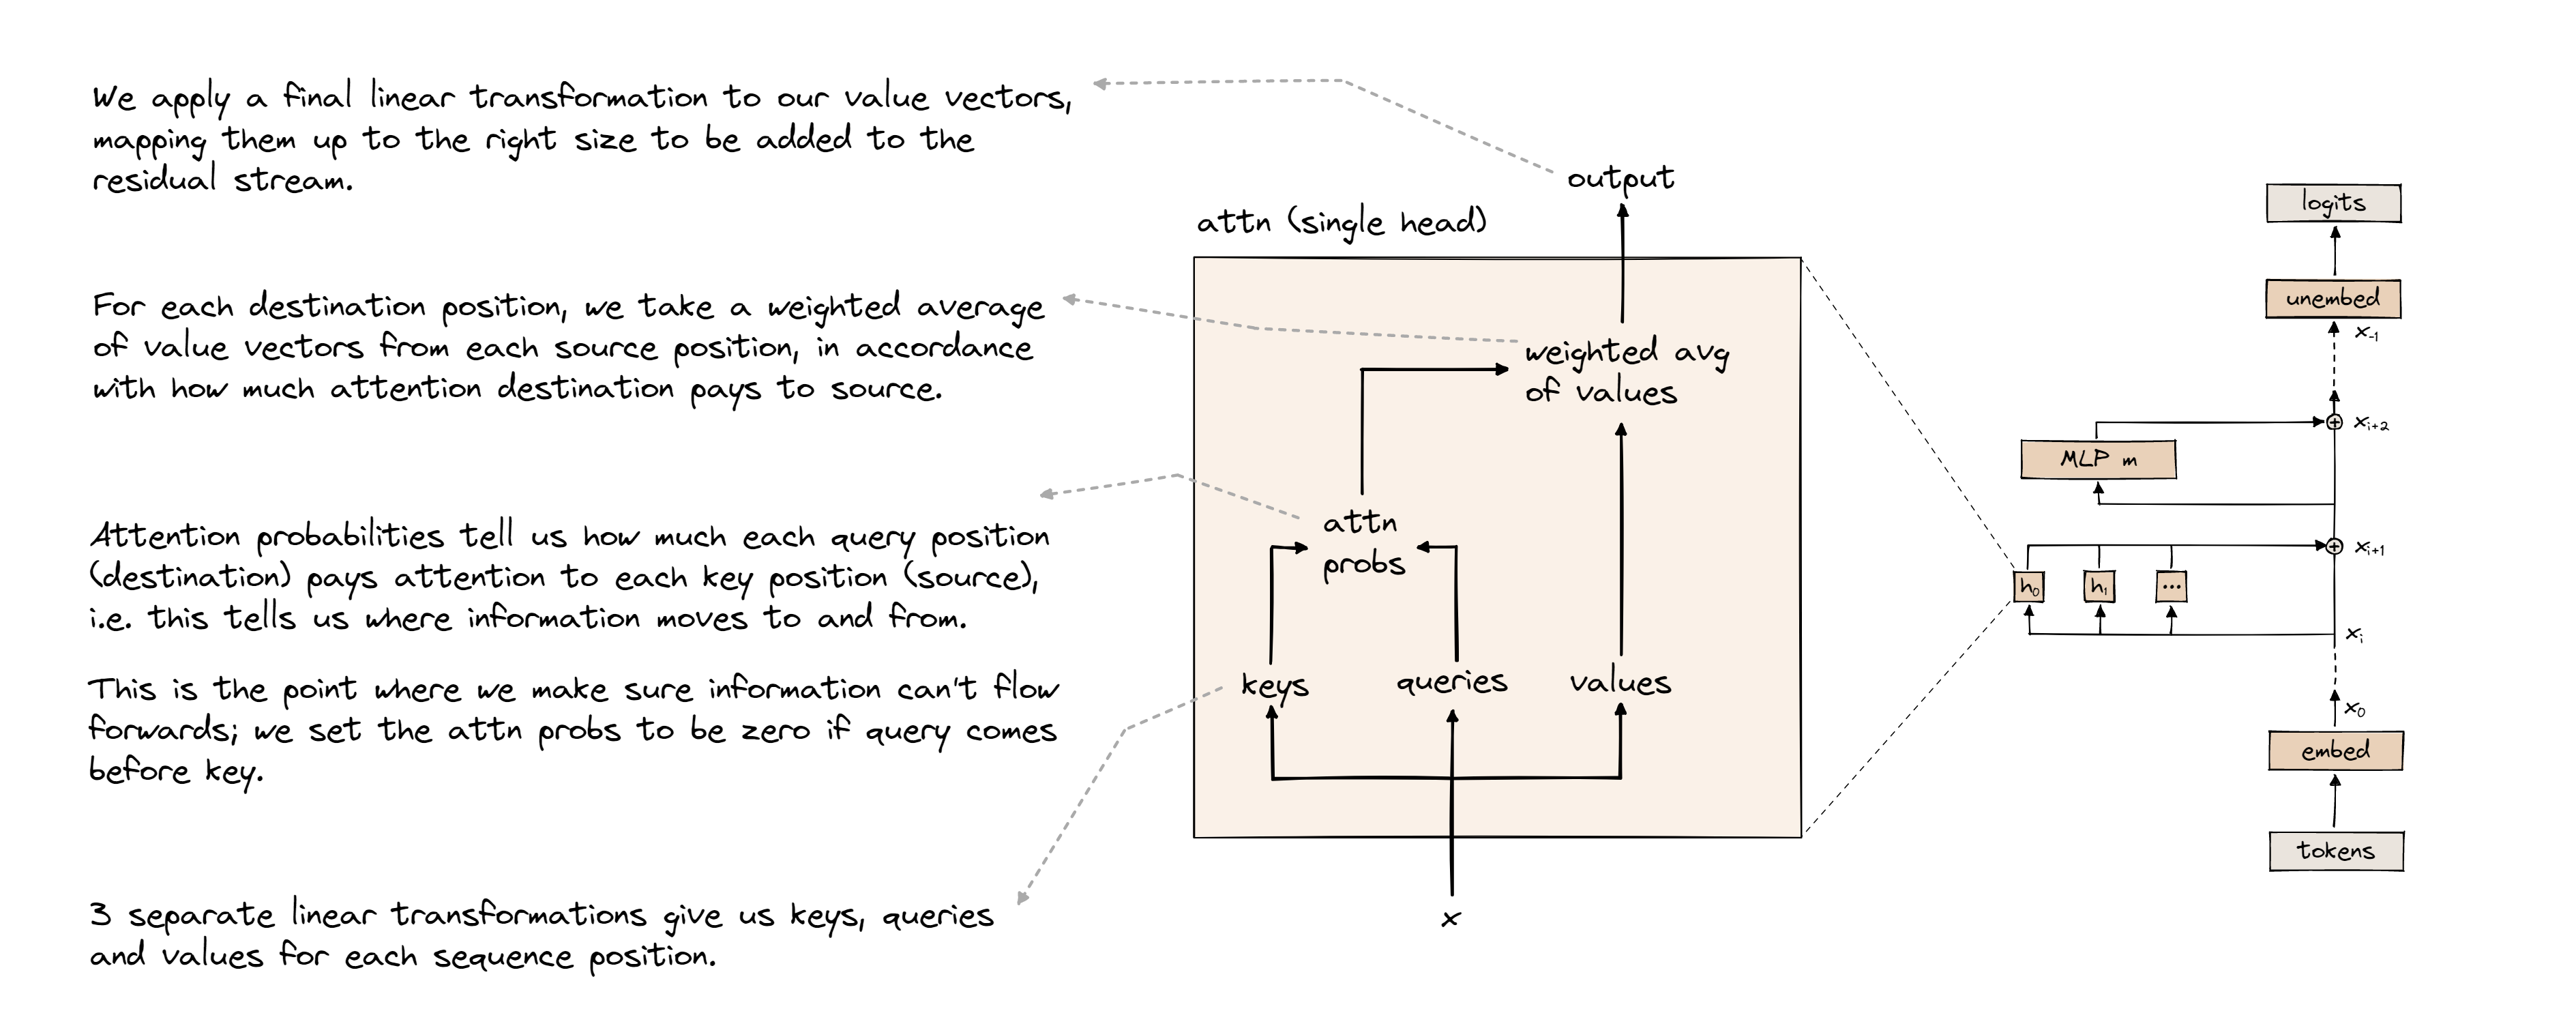

In this section, we will use the [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation) to define matrix multiplications. In particular, we will use the `einsum` function from the `einops` module ([link to docs](https://einops.rocks/api/einsum/)). This way, we can specify how we want to perform a multiplication between two matrices $A \in \mathbb{R}^{n\times m}$ and $B \in \mathbb{R}^{m\times k}$ in the following way:
```
einops.einsum(a, b, 'n m, m k -> n k')
```

Your task is to fill in the multiplication specifications within the einsum function calls. Replace the placeholder strings `[fill in pattern here]` with the correct dimensionality of the matrices involved, following the pattern `dimA1 dimA2..., dimB1, dimB2... -> dimRes1 dimRes2...`.


In [6]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE",torch.tensor(-1e5, dtype=torch.float32, device=device))

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        '''
        ones = torch.ones_like(attn_scores)
        mask = torch.triu(ones, diagonal=1)
        mask = mask.to(torch.bool)
        return attn_scores.masked_fill(mask, self.IGNORE)

    def forward(
        self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        # Linear Mapping: compute matrices Q, K, and V
        q = einops.einsum(normalized_resid_pre, self.W_Q, 'batch query_pos d_model, n_heads d_model d_head -> batch query_pos n_heads d_head') + self.b_Q
        k = einops.einsum(normalized_resid_pre, self.W_K, 'batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head') + self.b_K
        v = einops.einsum(normalized_resid_pre, self.W_V, 'batch posn d_model, n_heads d_model d_head -> batch posn n_heads d_head') + self.b_V

        # dot product to compute attention scores
        a = einops.einsum(q, k, 'batch query_pos n_heads d_head, batch key_pos n_heads d_head -> batch n_heads query_pos key_pos')

        # re-scale
        a = a / (self.cfg.d_head ** 0.5)

        # apply causal mask
        a = self.apply_causal_mask(a)

        # apply softmax
        a = a.softmax(dim=-1)

        # get weighted sum of values
        z = einops.einsum(a, v, 'batch n_heads query_pos posn, batch posn n_heads d_head -> batch query_pos n_heads d_head')

        # sum over different heads
        attn_out = einops.einsum(z, self.W_O, 'batch query_pos n_heads d_head, n_heads d_head d_model -> batch query_pos d_model') + self.b_O

        return attn_out


rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, cache["normalized", 0, "ln1"])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 13, 768])
Output shape: torch.Size([1, 13, 768])
Reference output shape: torch.Size([1, 13, 768]) 

100.00% of the values are correct



## Question 5: MLP (5 pts)

The Multi-Layer Perceptron (MLP) is a core component of the Transformer architecture, functioning as a powerful mechanism for capturing complex relationships in the data. Within a Transformer block, the MLP typically takes as input the sum of the residual stream and the output of the attention mechanism.
The MLP in a Transformer consists of two linear layers separated by a non-linear activation function.

Complete the `forward` method of the `MLP` class. The method receives an input tensor `normalized_resid_mid` with dimensions `[batch, posn, d_model]`, and needs to perform the following steps:
1. Apply the first linear transformation using `self.W_in` and `self.b_in` to the input tensor. This step increases the dimensionality from `d_model` to `d_mlp`.
2. Apply a non-linear activation function (GELU, the function `gelu_new` has been imported for this purpose) to the output of step 1.
3. Apply the second linear transformation using `self.W_out` and `self.b_out` to the result of step 2, reducing the dimensionality back to `d_model`.

**Hint:** here you can implement matrix multiplications using `torch.matmul(tensor1, tensor2)` or the equivalent `tensor1 @ tensor2` notation ([docs](https://pytorch.org/docs/stable/generated/torch.matmul.html)).

In [7]:
class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(torch.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(torch.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(torch.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(torch.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, normalized_resid_mid: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        # Apply the first linear transformation
        hidden_1 = torch.matmul(normalized_resid_mid, self.W_in) + self.b_in
        # Apply the GELU activation function
        hidden = gelu_new(hidden_1)
        # Apply the second linear transformation
        output = torch.matmul(hidden, self.W_out) + self.b_out
        return output

rand_float_test(MLP, [2, 4, 768])
load_gpt2_test(MLP, reference_gpt2.blocks[0].mlp, cache["normalized", 0, "ln2"])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 13, 768])
Output shape: torch.Size([1, 13, 768])
Reference output shape: torch.Size([1, 13, 768]) 

100.00% of the values are correct



## Q6: Transformer Block (3 pts)

Now, we can put together the attention, MLP and layernorms into a single transformer block.

**Warning:** refrain from using in-place operations (e.g., `x += y`) as they might lead to random test failuers due to small numerical differences.

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, resid_pre: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_model"]:
        #implement your solution here
        # Apply the first layer normalization and attention
        ln1 = self.ln1(resid_pre)
        attn_out = self.attn(ln1)
        # Add the residual connection
        resid_mid = attn_out + resid_pre
        # Apply the second layer normalization and MLP
        ln2 = self.ln2(resid_mid)
        mlp_out = self.mlp(ln2)
        # Add the residual connection again
        resid_post = mlp_out + resid_mid
        return resid_post

rand_float_test(TransformerBlock, [2, 4, 768])
load_gpt2_test(TransformerBlock, reference_gpt2.blocks[0], cache["resid_pre", 0])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 13, 768])
Output shape: torch.Size([1, 13, 768])
Reference output shape: torch.Size([1, 13, 768]) 

100.00% of the values are correct



## Q7: Unembedding (2 pts)


The unembedding layer transforms the dense vectors back into discrete token representations, effectively reversing the embedding process.
In the `forward` method, apply a linear transformation to the input tensor `normalized_resid_final` using `W_U` and `b_U`, converting the model's internal representations into logits over the vocabulary.



In [9]:
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(torch.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(torch.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, normalized_resid_final: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        #implement your solution here
        # Compute the logits by multiplying the final hidden states with the unembedding matrix
        logits = einops.einsum(normalized_resid_final, self.W_U, 'batch position d_model, d_model d_vocab -> batch position d_vocab')
        # Add the bias term
        logits = logits + self.b_U
        return logits

rand_float_test(Unembed, [2, 4, 768])
load_gpt2_test(Unembed, reference_gpt2.unembed, cache["ln_final.hook_normalized"])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257]) 

Input shape: torch.Size([1, 13, 768])
Output shape: torch.Size([1, 13, 50257])
Reference output shape: torch.Size([1, 13, 50257]) 

100.00% of the values are correct



## Q8: Full Transformer-based Model (3 pts)

This section describes the assembly of a complete Transformer-based model, integrating various components you've previously implemented.
The `DemoTransformer` class encapsulates the entire model architecture, starting from input token embeddings, adding positional information, processing through multiple Transformer blocks, and finally converting the processed embeddings back into logits over the vocabulary. Your task is to arrange these components within the model's `forward` method.

Hint: you can use a loop over `range(cfg.n_layers)`.

In [10]:
class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_vocab"]:
        #implement your solution here
        # Embed the tokens and add positional embeddings
        residual = self.embed(tokens) + self.pos_embed(tokens)
        # Pass through each Transformer block
        for block in self.blocks:
            residual = block(residual)
        # Apply final layer normalization
        normalized_resid_final = self.ln_final(residual)
        # Unembed to get logits
        logits = self.unembed(normalized_resid_final)
        return logits


rand_int_test(DemoTransformer, [2, 4])
load_gpt2_test(DemoTransformer, reference_gpt2, tokens)

Input shape: torch.Size([2, 4])
Output shape: torch.Size([2, 4, 50257]) 

Input shape: torch.Size([1, 13])
Output shape: torch.Size([1, 13, 50257])
Reference output shape: torch.Size([1, 13, 50257]) 

100.00% of the values are correct



## Q9: Generating Text From a Transformer (7 pts)

After assembling and validating the `DemoTransformer` model against the GPT-2 reference architecture, the next step is to bring your model to life by generating text. This section focuses on leveraging the weights of the pre-trained GPT-2 Small model to produce text, emphasizing the application of greedy decoding.

**Loading Pre-trained Weights**

Start by loading the pre-trained GPT-2 Small weights into your `DemoTransformer` model with the following code:


In [11]:
demo_gpt2 = DemoTransformer(Config(debug=False)).to(device)
demo_gpt2.load_state_dict(reference_gpt2.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['blocks.0.attn.mask', 'blocks.1.attn.mask', 'blocks.2.attn.mask', 'blocks.3.attn.mask', 'blocks.4.attn.mask', 'blocks.5.attn.mask', 'blocks.6.attn.mask', 'blocks.7.attn.mask', 'blocks.8.attn.mask', 'blocks.9.attn.mask', 'blocks.10.attn.mask', 'blocks.11.attn.mask'])


**Greedy Decoding**

Greedy decoding is a straightforward approach to text generation where, at each step, the model selects the word with the highest probability as its next output.
In this final section of the exercise, you will leverage the pre-trained GPT-2 Small model within your Transformer classes to generate text.
You are tasked with implementing a function named `greedy_decode` that generates text from an initial sequence of tokens. This function will utilize greedy decoding, selecting the most probable next token at each step.

- **Function Parameters:**
  - `model`: Your initialized and pre-trained `DemoTransformer` model.
  - `start_tokens`: A list of token IDs (integers) representing the initial sequence from which to start generating text.
  - `max_length`: The maximum total number of tokens to generate, including the initial sequence.

- **Decoding Logic:**
  - The function should begin with the provided `start_tokens` and iteratively generate additional tokens, appending each new token to the sequence.
  - At each step, the function selects the token with the highest probability as the next addition to the sequence.
  - Generation continues until either the `max_length` is reached or an end-of-sequence token is generated.

- **Return Value:**
  - The function should return a list of token IDs, representing the generated sequence including the initial tokens.

  **Hint:** use `tensor.argmax()` to get the token_id with highest logit/probability.

  **Hint:** use `tensor1 = torch.cat((tensor1, tensor2))` to append `tensor2` to `tensor1`.


In [12]:
def greedy_decode(model, start_tokens, max_new_tokens):
    """
    Generates text using greedy decoding from an initial sequence of tokens.

    Parameters:
    - model: The pre-trained DemoTransformer model.
    - start_tokens: A list of initial tokens (integers) to start the text generation.
    - max_new_tokens: The maximum number of new tokens to generate.

    Returns:
    - A list of generated token IDs, including the start_tokens.
    """
    with torch.no_grad():  # Disable gradient calculation for inference
        generated = start_tokens # Shape: [1, seq_len]
        # implement your solution here
        eos_token_id = 50256  # EOS token ID for GPT-2
        for _ in range(max_new_tokens):
            # Get the logits for the current sequence of tokens
            logits = model(generated)
            # Get the last token's logits
            last_token_logits = logits[:, -1, :]
            # Select the token with the highest probability (greedy decoding)
            next_token = last_token_logits.argmax(dim=-1, keepdim=True)
            # Append the new token to the generated sequence
            generated = torch.cat((generated, next_token), dim=1)
            # If the new token is the eos token, break the loop
            if next_token.item() == eos_token_id:
                break
        # Convert the generated tokens to a list and return
        generated = generated.squeeze(0).tolist()
        
    return generated

#### Test your implementation

Run the following cell (without editing it!) to verify that your implementation is correct.

In [13]:
start_sequence = "Today I was walking home, when suddenly"
start_tokens = reference_gpt2.to_tokens(start_sequence, prepend_bos=True)
max_new_tokens = 20  # Maximum number of tokens to generate

# Generate tokens using greedy decoding
generated_tokens = greedy_decode(demo_gpt2, start_tokens, max_new_tokens)

# Decode generated tokens back to text
generated_text = reference_gpt2.to_string(generated_tokens[1:])
print("Generated Text:", generated_text)

reference_generation = reference_gpt2.generate(start_sequence, max_new_tokens=max_new_tokens, stop_at_eos=False, do_sample=False)
assert reference_generation == generated_text, f'{reference_generation} vs {generated_text}'
print('The generations match!')

Generated Text: Today I was walking home, when suddenly I heard a loud bang. I looked up and saw a man in a white shirt and a black


  0%|          | 0/20 [00:00<?, ?it/s]

The generations match!
